# **Dependences**

In [ ]:
import getpass
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import numpy as np

# **Data Download**

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("balraj98/indoor-training-set-its-residestandard")

print("Path to dataset files:", path)

100%|██████████| 4.74G/4.74G [00:55<00:00, 91.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/indoor-training-set-its-residestandard/versions/1


# **Data Loader**

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import ast
import pandas as pd

class HazyDatasetWithMetadata(Dataset):
    def __init__(self, metadata_df, root_dir, transform=None):
        """
        Dataset for hazy image dehazing using metadata.

        Args:
            metadata_df (pd.DataFrame): DataFrame with metadata.
            root_dir (str): Root directory containing dataset folders.
            transform (callable, optional): Transformations for images.
        """
        self.metadata = metadata_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Extract clear image and corresponding hazy and transmission map paths
        clear_path = os.path.join(self.root_dir, self.metadata.loc[idx, "clear_image_path"])
        hazy_paths = ast.literal_eval(self.metadata.loc[idx, "hazy_image_paths"])  # Convert string list to list
        trans_paths = ast.literal_eval(self.metadata.loc[idx, "trans_image_paths"])  # Convert string list to list

        # Load clear image
        clear_image = Image.open(clear_path).convert("RGB")

        # Load one hazy image and corresponding transmission map
        hazy_path = os.path.join(self.root_dir, hazy_paths[0])  # Pick the first hazy image
        trans_path = os.path.join(self.root_dir, trans_paths[0])  # Pick the first transmission map

        hazy_image = Image.open(hazy_path).convert("RGB")
        trans_image = Image.open(trans_path).convert("RGB")

        # Apply transformations if defined
        if self.transform:
            clear_image = self.transform(clear_image)
            hazy_image = self.transform(hazy_image)
            trans_image = self.transform(trans_image)

        return {"clear": clear_image, "hazy": hazy_image, "trans": trans_image}


# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a uniform size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Root directory where the dataset folders are located
root_dir = path
metadata_path = "/content/metadata.csv"
# Load the metadata file
metadata = pd.read_csv(metadata_path)

# Create the dataset and dataloader
dataset = HazyDatasetWithMetadata(metadata_df=metadata, root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Test the DataLoader
sample_batch = next(iter(dataloader))

# Display the shapes of loaded data
sample_batch.keys(), sample_batch["clear"].shape, sample_batch["hazy"].shape, sample_batch["trans"].shape


(dict_keys(['clear', 'hazy', 'trans']),
 torch.Size([4, 3, 256, 256]),
 torch.Size([4, 3, 256, 256]),
 torch.Size([4, 3, 256, 256]))

# **Data Visualizer**

In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(dataloader):
    """
    Visualize a batch of clear, hazy, and transmission map images from the DataLoader.

    Args:
        dataloader: PyTorch DataLoader with batches of data.
    """
    for batch in dataloader:
        clear_images = batch['clear']  # Clear images
        hazy_images = batch['hazy']   # Hazy images
        trans_images = batch['trans'] # Transmission maps

        batch_size = clear_images.size(0)  # Number of images in the batch
        fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

        for i in range(batch_size):
            # Plot Clear Images
            axes[i, 0].imshow(clear_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Denormalize for display
            axes[i, 0].set_title("Clear Image")
            axes[i, 0].axis('off')

            # Plot Hazy Images
            axes[i, 1].imshow(hazy_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Denormalize for display
            axes[i, 1].set_title("Hazy Image")
            axes[i, 1].axis('off')

            # Plot Transmission Maps
            axes[i, 2].imshow(trans_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Denormalize for display
            axes[i, 2].set_title("Transmission Map")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()
        break  # Visualize only one batch


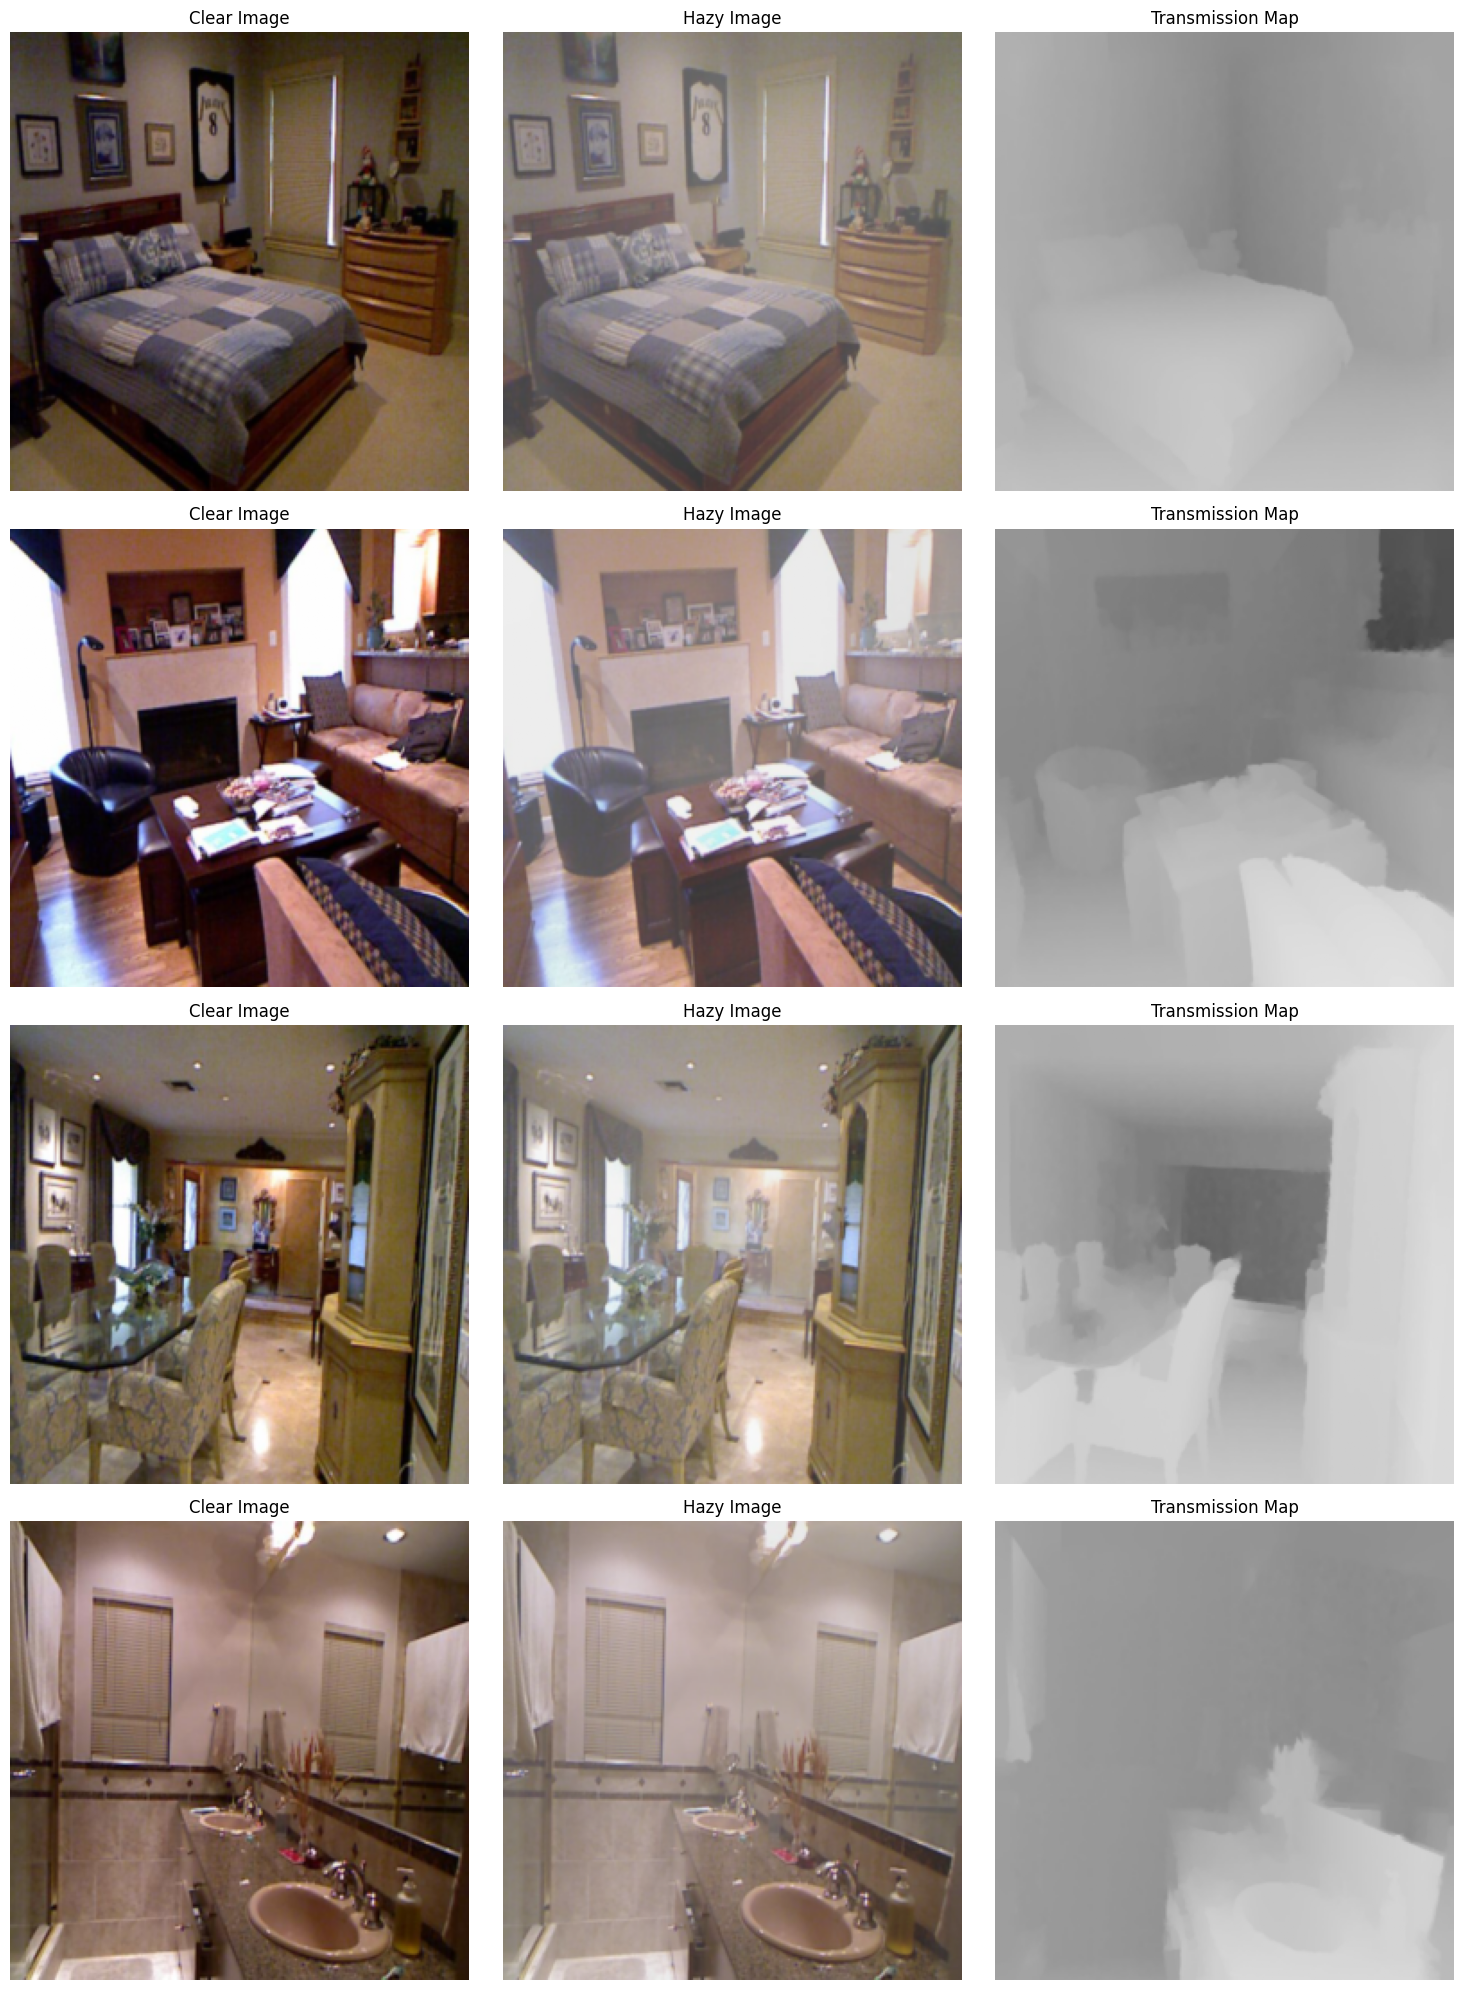

In [ ]:
visualize_batch(dataloader)

# **CNN**

In [ ]:
class RefinementNet(nn.Module):
    def __init__(self):
        super(RefinementNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


# **Tarnsmission Map (TM)**

In [ ]:
import numpy as np
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def dark_channel(image, patch_size=1):
    """
    Compute the dark channel of an image.
    Args:
        image: Input image (H x W x C) in RGB format.
        patch_size: Size of the patch for min filter.
    Returns:
        dark_channel: Dark channel of the image.
    """
    # Convert the image to numpy array and normalize to [0, 1]
    image = np.array(image) / 255.0

    # Compute the dark channel by taking the minimum across RGB channels
    min_channel = np.min(image, axis=2)

    # Apply a minimum filter (erosion) with a square kernel
    dark_channel = cv2.erode(min_channel, np.ones((patch_size, patch_size)))

    return dark_channel

def atmospheric_light(image, dark_channel):
    """
    Estimate the atmospheric light from the image using the dark channel.
    Args:
        image: The input image (H x W x C).
        dark_channel: The computed dark channel of the image.
    Returns:
        A: Estimated atmospheric light (RGB).
    """
    # Flatten the dark channel to 1D array
    dark_channel_flat = dark_channel.flatten()

    # Get indices of the top 0.1% brightest pixels in the dark channel
    indices = dark_channel_flat.argsort()[-int(0.001 * len(dark_channel_flat)):]

    # Get the corresponding RGB values of these pixels from the image
    top_pixels = image.reshape(-1, 3)[indices]

    # Average the RGB values of the top brightest pixels
    A = np.mean(top_pixels, axis=0)

    return A

def transmission_map(image, A, omega=0.95, patch_size=1):
    """
    Compute the transmission map for an image.
    Args:
        image: The input image (H x W x C).
        A: The estimated atmospheric light.
        omega: A constant (usually 0.95).
        patch_size: Size of the patch for computing the dark channel.
    Returns:
        transmission_map: The computed transmission map.
    """
    # Compute the dark channel
    dark = dark_channel(image, patch_size)

    # Normalize the dark channel by the atmospheric light
    transmission = 1 - omega * dark / A.min()  # A.min() to handle the RGB channels separately

    # Clip transmission values to [0, 1]
    transmission_map = np.clip(transmission, 0, 1)

    return transmission_map

def create_transmission_map(image_path):
    """
    Create the transmission map for a custom image.
    Args:
        image_path: Path to the input image.
    Returns:
        transmission_map: The computed transmission map.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Convert image to numpy array
    image_np = np.array(image)

    # Step 1: Compute Dark Channel
    dark = dark_channel(image)

    # Step 2: Estimate Atmospheric Light
    A = atmospheric_light(image_np, dark)

    # Step 3: Compute the Transmission Map
    transmission = transmission_map(image_np, A)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np / 255.0)  # Display the original image
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transmission, cmap='gray')  # Display the transmission map
    plt.title("Transmission Map")
    plt.axis('off')

    plt.show()

    return transmission

# Example usage:
image_path = '/content/testD.jpg'  # Replace with your image path
transmission_map = create_transmission_map(image_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/testD.jpg'

# **Training without TM**

In [ ]:
# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
learning_rate = 0.001
save_path = "dehazer.pth"

# Instantiate the deep learning model
model = RefinementNet().to(device)  # Move model to the appropriate device (cuda or cpu)

# Define optimizer and loss function (if not defined inside the model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Ensure the model is in training mode
model.train()

# Train the model using the dataloader and training parameters
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Extract hazy and clear images from the batch
        hazy_images = batch['hazy'].to(device)  # Input hazy images
        clear_images = batch['clear'].to(device)  # Ground truth clear images

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model (no DCP preprocessing)
        refined_output = model(hazy_images)

        # Compute the loss between the refined output and the clear images
        loss = criterion(refined_output, clear_images)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        epoch_loss += loss.item()

    # Log the epoch loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch [1/10], Loss: 0.0818
Epoch [2/10], Loss: 0.0696
Epoch [3/10], Loss: 0.0675
Epoch [4/10], Loss: 0.0653
Epoch [5/10], Loss: 0.0630
Epoch [6/10], Loss: 0.0616
Epoch [7/10], Loss: 0.0625
Epoch [8/10], Loss: 0.0621
Epoch [9/10], Loss: 0.0602
Epoch [10/10], Loss: 0.0590
Model saved to dehazer.pth


# **Training with TM**

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Assuming the RefinementNet model is defined somewhere
# and 'dataloader' is already initialized

def dark_channel(image, patch_size=1):
    """
    Compute the dark channel of an image.
    Args:
        image: Input image (H x W x C) in RGB format.
        patch_size: Size of the patch for min filter.
    Returns:
        dark_channel: Dark channel of the image.
    """
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    min_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(min_channel, np.ones((patch_size, patch_size)))  # Erosion (min filter)
    return dark_channel

def atmospheric_light(image, dark_channel):
    """
    Estimate the atmospheric light from the image using the dark channel.
    Args:
        image: The input image (H x W x C).
        dark_channel: The computed dark channel of the image.
    Returns:
        A: Estimated atmospheric light (RGB).
    """
    dark_channel_flat = dark_channel.flatten()
    indices = dark_channel_flat.argsort()[-int(0.001 * len(dark_channel_flat)):]  # Top 0.1%
    top_pixels = image.reshape(-1, 3)[indices]
    A = np.mean(top_pixels, axis=0)
    return A

def transmission_map(image, A, omega=0.95, patch_size=1):
    """
    Compute the transmission map for an image.
    Args:
        image: The input image (H x W x C).
        A: The estimated atmospheric light.
        omega: A constant (usually 0.95).
        patch_size: Size of the patch for computing the dark channel.
    Returns:
        transmission_map: The computed transmission map.
    """
    dark = dark_channel(image, patch_size)
    transmission = 1 - omega * dark / A.min()  # A.min() to handle RGB channels
    transmission_map = np.clip(transmission, 0, 1)
    return transmission_map

# Instantiate the deep learning model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RefinementNet().to(device)  # Move model to the appropriate device (cuda or cpu)

# Training parameters
epochs = 10
learning_rate = 0.001
save_path = "dehazer_TM.pth"

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Ensure the model is in training mode
model.train()

# Train the model using the dataloader and training parameters
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Extract hazy and clear images from the batch
        hazy_images = batch['hazy'].to(device)  # Input hazy images
        clear_images = batch['clear'].to(device)  # Ground truth clear images

        # Preprocess hazy images using transmission map (DCP preprocessing)
        hazy_images_np = hazy_images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC format
        processed_hazy_images = []

        for image in hazy_images_np:
            # Calculate transmission map for each image
            A = atmospheric_light(image, dark_channel(image))
            transmission = transmission_map(image, A)

            # Apply transmission map to hazy image (adjust hazy image by transmission map)
            processed_image = image * transmission[:, :, np.newaxis]
            processed_hazy_images.append(processed_image)

        # Convert back to PyTorch tensor
        processed_hazy_images = np.array(processed_hazy_images).transpose(0, 3, 1, 2)
        processed_hazy_images_tensor = torch.from_numpy(processed_hazy_images).float().to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        refined_output = model(processed_hazy_images_tensor)

        # Compute the loss between the refined output and the clear images
        loss = criterion(refined_output, clear_images)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        epoch_loss += loss.item()

    # Log the epoch loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch [1/10], Loss: 0.0855
Epoch [2/10], Loss: 0.0690
Epoch [3/10], Loss: 0.0686
Epoch [4/10], Loss: 0.0645
Epoch [5/10], Loss: 0.0650
Epoch [6/10], Loss: 0.0633
Epoch [7/10], Loss: 0.0625
Epoch [8/10], Loss: 0.0614
Epoch [9/10], Loss: 0.0603
Epoch [10/10], Loss: 0.0611
Model saved to dehazer_TM.pth


# **Testing**

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

def test_single_image(model, image_path, transform, device):
    """
    Test a single image with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_path (str): Path to the image to be tested.
        transform (callable): Transformations applied to the image.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        output_image: The dehazed output image.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():  # No need to track gradients during testing
        # Forward pass through the model
        output_image_tensor = model(image_transformed)

    # Convert output tensor to numpy for visualization
    output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Clip values to [0, 1] for valid image display
    output_image = np.clip(output_image, 0, 1)

    # Plot the original and dehazed images for comparison
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
    plt.title("Original Image")
    plt.axis('off')

    # Plot dehazed image
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Dehazed Image")
    plt.axis('off')

    plt.show()

    return output_image

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer.pth"))
model.eval()

# Test on a single image
image_path = 'testD.jpg'  # Replace with the path to the image you want to test
output_image = test_single_image(model, image_path, transform, device)


<ipython-input-15-915120c723b8>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dehazer_TM.pth"))


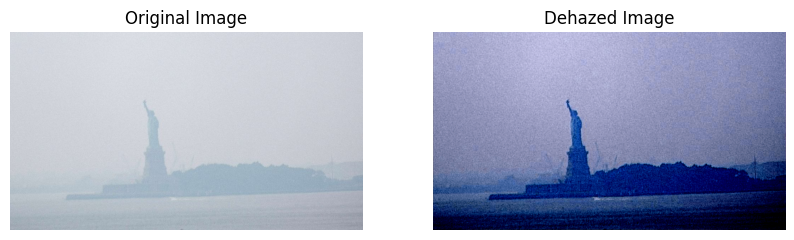

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

def test_single_image(model, image_path, transform, device):
    """
    Test a single image with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_path (str): Path to the image to be tested.
        transform (callable): Transformations applied to the image.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        output_image: The dehazed output image.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():  # No need to track gradients during testing
        # Forward pass through the model
        output_image_tensor = model(image_transformed)

    # Convert output tensor to numpy for visualization
    output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Clip values to [0, 1] for valid image display
    output_image = np.clip(output_image, 0, 1)

    # Plot the original and dehazed images for comparison
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
    plt.title("Original Image")
    plt.axis('off')

    # Plot dehazed image
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Dehazed Image")
    plt.axis('off')

    plt.show()

    return output_image

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer_TM.pth"))
model.eval()

# Test on a single image
image_path = 'testD.jpg'  # Replace with the path to the image you want to test
output_image = test_single_image(model, image_path, transform, device)


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

def test_multiple_images(model, image_dir, transform, device, num_samples=10):
    """
    Test multiple images with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_dir (str): Directory containing images to be tested.
        transform (callable): Transformations applied to the images.
        device: Device to run the model on ('cuda' or 'cpu').
        num_samples (int): Number of images to process.

    Returns:
        output_images: List of dehazed output images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_files = image_files[:num_samples]  # Limit to the specified number of samples

    output_images = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():  # No need to track gradients during testing
            # Forward pass through the model
            output_image_tensor = model(image_transformed)

        # Convert output tensor to numpy for visualization
        output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] for valid image display
        output_image = np.clip(output_image, 0, 1)
        output_images.append(output_image)

        # Plot the original and dehazed images for comparison
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
        plt.title(f"Original Image: {image_file}")
        plt.axis('off')

        # Plot dehazed image
        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title("Dehazed Image")
        plt.axis('off')

        plt.show()

    return output_images

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer.pth"))
model.eval()

# Directory containing images
# Choose a specific index from the metadata DataFrame
idx = 0  # You can change this to any valid index within the range of your metadata
image_dir = os.path.dirname(os.path.join(root_dir, metadata.loc[idx, "hazy_image_path"]))


# Test on multiple images
output_images = test_multiple_images(model, image_dir, transform, device, num_samples=10)

<ipython-input-40-9cb501e29885>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dehazer.pth"))


KeyError: 'hazy_image_path'

<ipython-input-10-4128fe3f3339>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dehazer_TM.pth"))


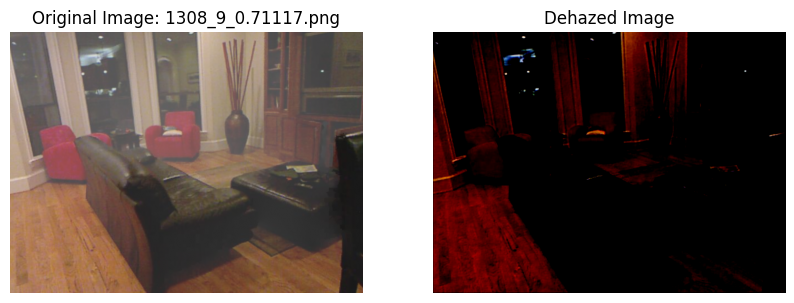

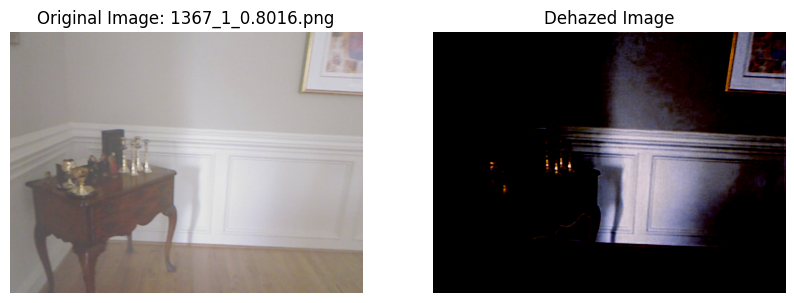

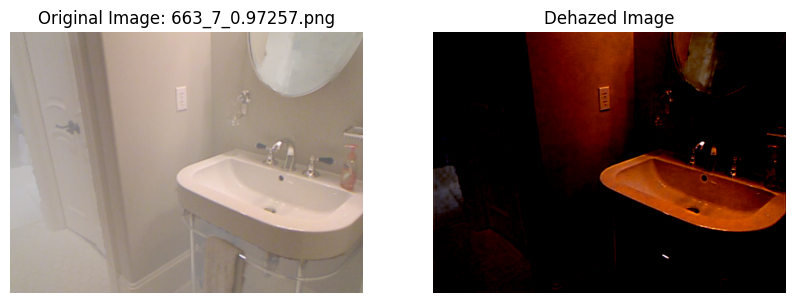

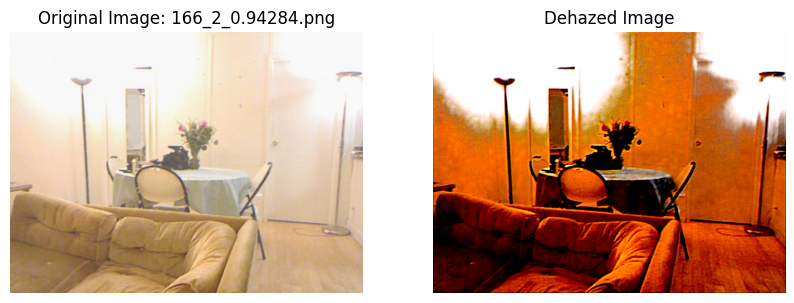

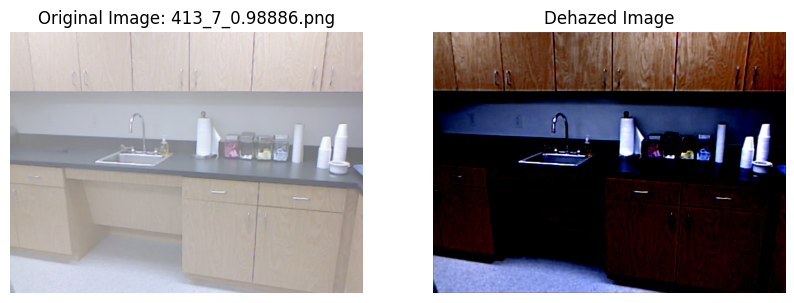

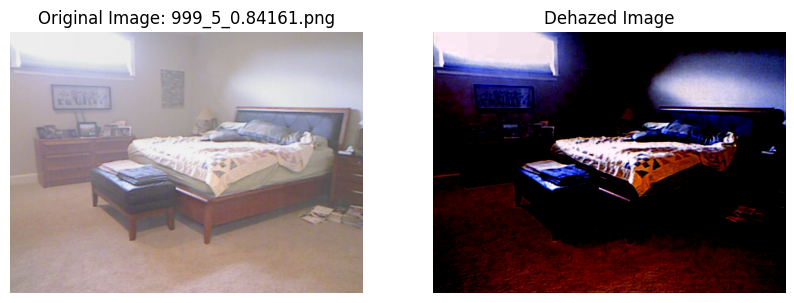

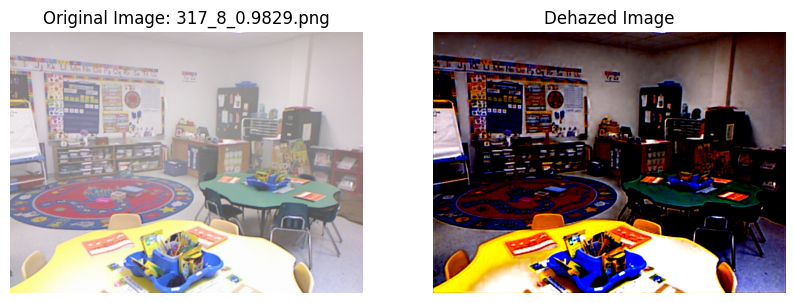

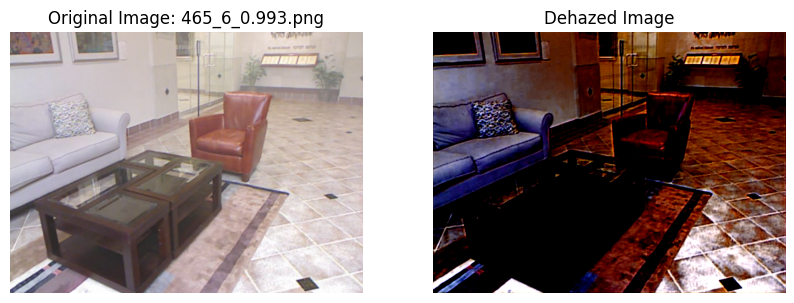

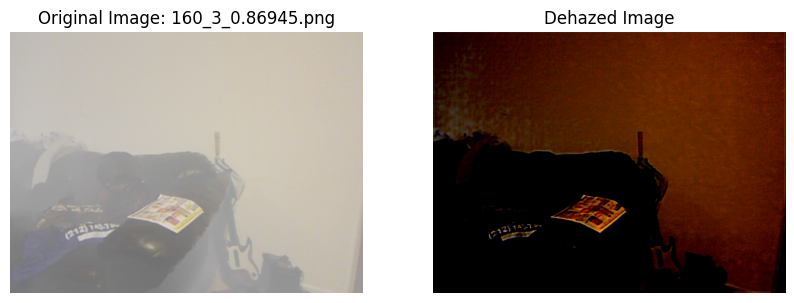

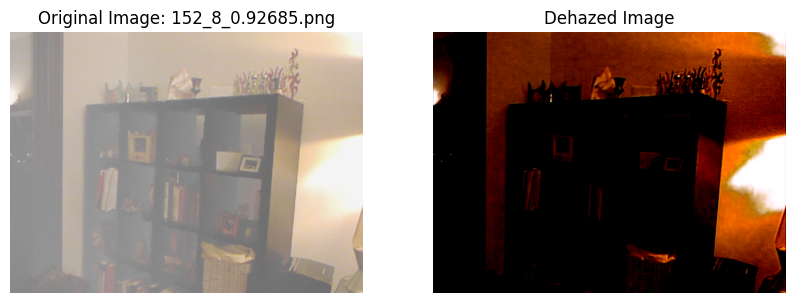

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

def test_multiple_images(model, image_dir, transform, device, num_samples=10):
    """
    Test multiple images with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_dir (str): Directory containing images to be tested.
        transform (callable): Transformations applied to the images.
        device: Device to run the model on ('cuda' or 'cpu').
        num_samples (int): Number of images to process.

    Returns:
        output_images: List of dehazed output images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_files = image_files[:num_samples]  # Limit to the specified number of samples

    output_images = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():  # No need to track gradients during testing
            # Forward pass through the model
            output_image_tensor = model(image_transformed)

        # Convert output tensor to numpy for visualization
        output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] for valid image display
        output_image = np.clip(output_image, 0, 1)
        output_images.append(output_image)

        # Plot the original and dehazed images for comparison
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
        plt.title(f"Original Image: {image_file}")
        plt.axis('off')

        # Plot dehazed image
        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title("Dehazed Image")
        plt.axis('off')

        plt.show()

    return output_images

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer_TM.pth"))
model.eval()

# Directory containing images
# Choose a specific index from the metadata DataFrame
idx = 0  # You can change this to any valid index within the range of your metadata
image_dir = os.path.dirname(os.path.join(root_dir, ast.literal_eval(metadata.loc[idx, "hazy_image_paths"])[0]))


# Test on multiple images
output_images = test_multiple_images(model, image_dir, transform, device, num_samples=10)

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

def test_multiple_images(model, image_dir, transform, device, num_samples=10):
    """
    Test multiple images with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_dir (str): Directory containing images to be tested.
        transform (callable): Transformations applied to the images.
        device: Device to run the model on ('cuda' or 'cpu').
        num_samples (int): Number of images to process.

    Returns:
        output_images: List of dehazed output images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_files = image_files[:num_samples]  # Limit to the specified number of samples

    output_images = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():  # No need to track gradients during testing
            # Forward pass through the model
            output_image_tensor = model(image_transformed)

        # Convert output tensor to numpy for visualization
        output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] for valid image display
        output_image = np.clip(output_image, 0, 1)
        output_images.append(output_image)

        # Plot the original and dehazed images for comparison
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
        plt.title(f"Original Image: {image_file}")
        plt.axis('off')

        # Plot dehazed image
        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title("Dehazed Image")
        plt.axis('off')

        plt.show()

    return output_images

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer.pth"))
model.eval()

# Directory containing images
# Choose a specific index from the metadata DataFrame
idx = 0  # You can change this to any valid index within the range of your metadata
image_dir = os.path.dirname(os.path.join(root_dir, ast.literal_eval(metadata.loc[idx, "hazy_image_paths"])[0]))


# Test on multiple images
output_images = test_multiple_images(model, image_dir, transform, device, num_samples=10)

<ipython-input-9-8a72ea105419>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dehazer_TM.pth"))


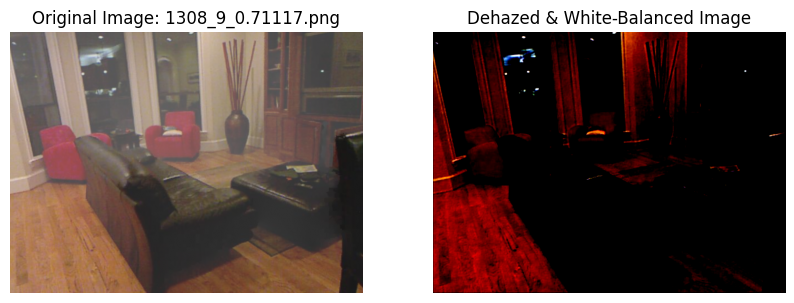

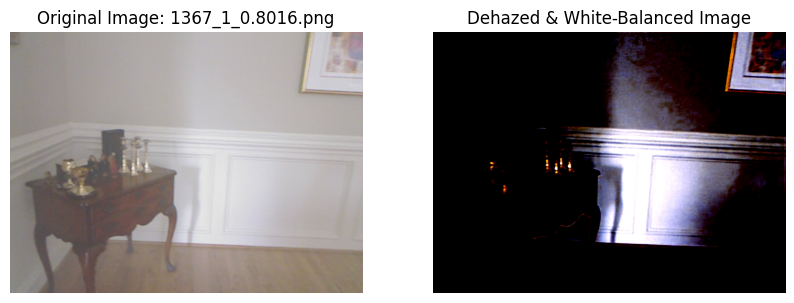

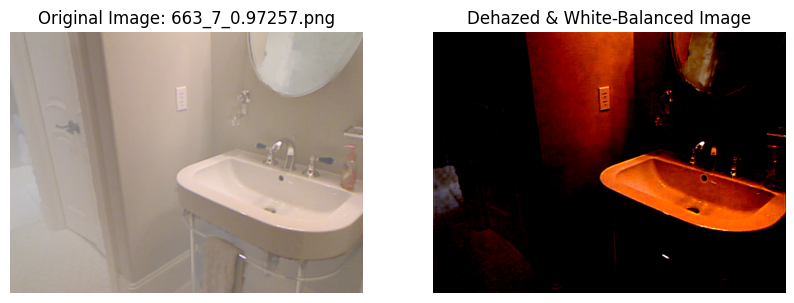

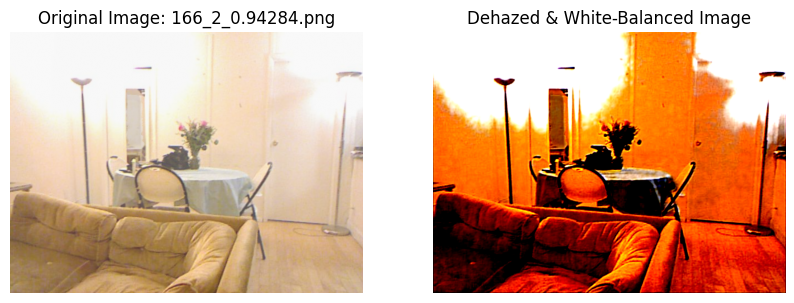

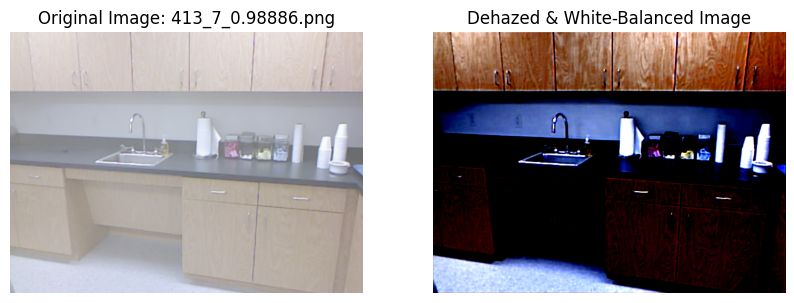

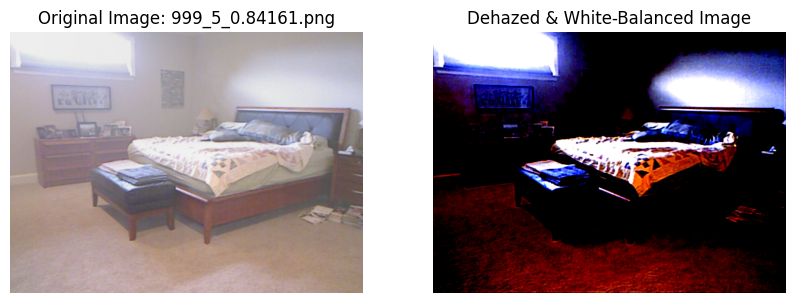

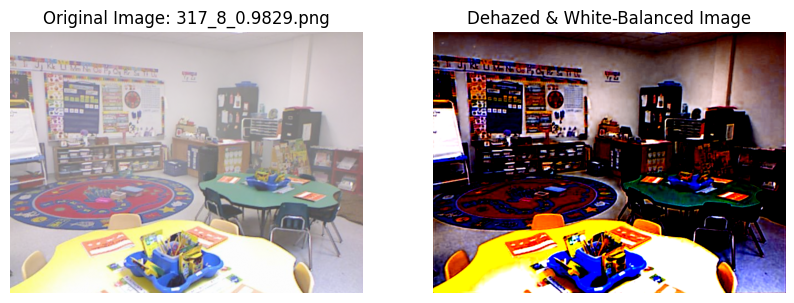

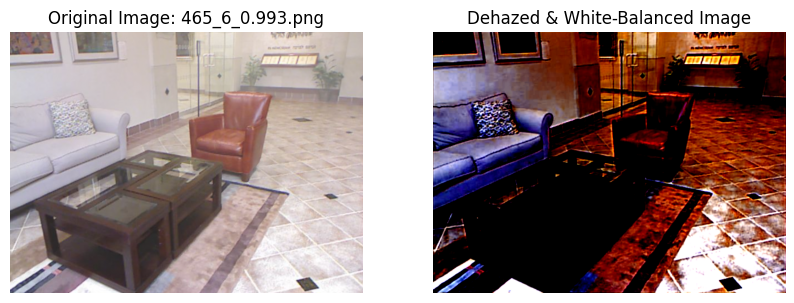

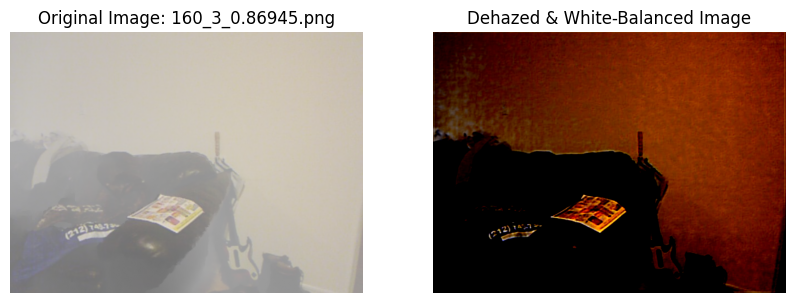

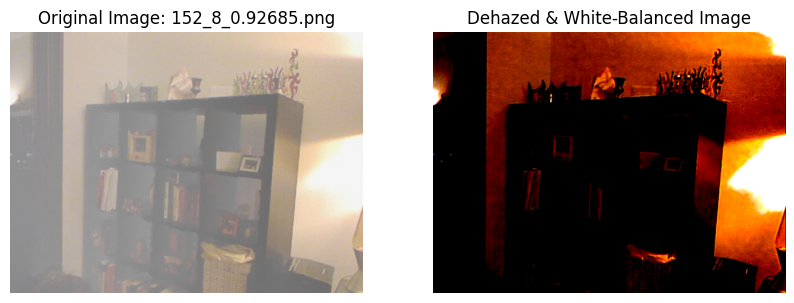

In [ ]:
import os
import torch
from PIL import Image, ImageEnhance
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import ast

def adjust_white_balance(image_array, factor=1.2):
    """
    Adjust the white balance of an image.

    Parameters:
        image_array (np.ndarray): Input image as a NumPy array.
        factor (float): Factor to enhance brightness/contrast.

    Returns:
        np.ndarray: White-balanced image array.
    """
    image = Image.fromarray((image_array * 255).astype(np.uint8))  # Convert to PIL Image
    enhancer = ImageEnhance.Brightness(image)  # Adjust brightness
    image = enhancer.enhance(factor)
    enhancer = ImageEnhance.Contrast(image)  # Adjust contrast
    image = enhancer.enhance(factor)
    return np.array(image) / 255.0  # Convert back to NumPy array (normalized)

def test_multiple_images(model, image_dir, transform, device, num_samples=10):
    """
    Test multiple images with the trained model.

    Parameters:
        model: The trained model (PyTorch model).
        image_dir (str): Directory containing images to be tested.
        transform (callable): Transformations applied to the images.
        device: Device to run the model on ('cuda' or 'cpu').
        num_samples (int): Number of images to process.

    Returns:
        output_images: List of dehazed output images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_files = image_files[:num_samples]  # Limit to the specified number of samples

    output_images = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():  # No need to track gradients during testing
            # Forward pass through the model
            output_image_tensor = model(image_transformed)

        # Convert output tensor to numpy for visualization
        output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] for valid image display
        output_image = np.clip(output_image, 0, 1)

        # Adjust white balance of the dehazed image
        output_image = adjust_white_balance(output_image, factor=1.2)

        output_images.append(output_image)

        # Plot the original and dehazed images for comparison
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image) / 255.0)  # Convert image to float between 0 and 1
        plt.title(f"Original Image: {image_file}")
        plt.axis('off')

        # Plot dehazed and white-balanced image
        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title("Dehazed & White-Balanced Image")
        plt.axis('off')

        plt.show()

    return output_images

# Example usage:
# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer_TM.pth"))
model.eval()

# Directory containing images
# Choose a specific index from the metadata DataFrame
idx = 0  # You can change this to any valid index within the range of your metadata
image_dir = os.path.dirname(os.path.join(root_dir, ast.literal_eval(metadata.loc[idx, "hazy_image_paths"])[0]))

# Test on multiple images
output_images = test_multiple_images(model, image_dir, transform, device, num_samples=10)


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


#**GUI**

In [ ]:
import gradio as gr
import torch
from PIL import Image
from torchvision import transforms
import numpy as np

# Define the function for testing a single image
def test_single_image(image):
    """
    Process the uploaded image with the trained model.

    Parameters:
        image: Uploaded image (PIL Image).

    Returns:
        Dehazed image (PIL Image).
    """
    # Apply transformations
    image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():  # No need to track gradients during testing
        # Forward pass through the model
        output_image_tensor = model(image_transformed)

    # Convert output tensor to numpy
    output_image = output_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Clip values to [0, 1] for valid image display
    output_image = np.clip(output_image, 0, 1)

    # Convert to PIL Image for output
    output_image = (output_image * 255).astype(np.uint8)  # Scale back to [0, 255]
    return Image.fromarray(output_image)

# Define transformations (must match the ones used during training)
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefinementNet().to(device)
model.load_state_dict(torch.load("dehazer_TM.pth"))
model.eval()

# Define the Gradio interface
interface = gr.Interface(
    fn=test_single_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Image(type="pil", label="Dehazed Image"),
    title="Image Dehazing Tool",
    description="Upload a hazy image, and this tool will process it using a trained dehazing model to generate a clearer version."
)

# Launch the interface
if __name__ == "__main__":
    interface.launch()


<ipython-input-7-6a2334b280a9>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dehazer_TM.pth"))


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29953a3e58316e30e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
